In [20]:
#simple direct problem solving 
import matplotlib.pyplot as plt

from clspde.solution import Solution
from clspde.basis import Basis
import itertools
import numpy as np

power = 6
params = {
        'n_dims': 2,
        'dim_sizes': np.array([8, 8]),
        'area_lims': np.array([[0,0.1], [0,1]]),
        'power': power,
        'basis': Basis(power),
        'n_funcs': 1,
    }

def alpha(x):
    return x[1]**2

def prepare_model(border_weight, colloc_weight, connect_weights, c):
    sigma = 0.5

    sol = Solution(**params)

    w = 1
    k1 = connect_weights[0]
    k2 = connect_weights[1]

    colloc_left_operators = [lambda u_loc, u_bas, x, x_loc:  (u_bas([1,0],0)+u_bas([0,2],0)/2*sigma**2
                                                                                            ) * w**2*colloc_weight,
                                                                                                ]



    # colloc_right_operators = [lambda u_loc, u_nei, x, x_loc:  c * alpha(x)**2  * colloc_weight,
    #                         ]

    # colloc_right_operators = [lambda u_loc, u_nei, x, x_loc: (( (c-x[0]) * alpha(x) )**2) * colloc_weight,
    #                         ]

    
    colloc_right_operators = [lambda u_loc, u_nei, x, x_loc: ( (c-x[0]) * (alpha(x))**2) * colloc_weight,
                            ]

    colloc_ops = [colloc_left_operators, colloc_right_operators]
        
    small = 1e-5

    def Bx(x):
        #border condition for x
        # return int((x[0]>sol.area_lims[0,0]+small) and (x[0]<sol.area_lims[0,1]-small))
        return int((x[1]==sol.area_lims[1,0]) or (x[1]==sol.area_lims[1,1]))

    def BtI(x):
        #border condition Initial for t
        return int(x[0]==sol.area_lims[0,0])

    def BtT(x):
        #border condtition Terminal for t
        return int(x[0]==sol.area_lims[0,1])

    border_left_operators = [
        lambda _, u_bas, x, x_loc: Bx(x)*u_bas([0,1],0) * border_weight,
        lambda _, u_bas, x, x_loc: BtT(x)*u_bas([0,0],0) * border_weight,
        ]

    border_right_operators = [
        lambda u, _, x, x_loc: Bx(x)*0 * border_weight,
        lambda u, _, x, x_loc: BtT(x)*0 * border_weight,
    ]

    border_ops = [border_left_operators, border_right_operators]

    def f_collocation_points(N):
        points = np.zeros(N+1)
        h = 2/(N+1)
        points[0] = -1 + h/2
        for i in range(1, N+1):
            points[i] = points[i-1] + h
        return np.array(points).reshape(N+1,1)

    c_p_1d = f_collocation_points(power).reshape(power+1)

    colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))
    connect_points = np.array([
                                [-1, 0.5], [1, 0.5],
                                [0.5, -1], [0.5, 1],
                                [-1, -0.5], [1, -0.5],
                                [-0.5, -1], [-0.5, 1],
                                [-1, 0], [1, 0],
                                [0, -1], [0, 1],
                                ])
    border_points = np.array([
                                [-1, 0.25], [-1, -0.25],
                                [-1, 0.75], [-1, -0.75],
                                
                                [0.25, -1], [0.25, -1],
                                [0.75, -1], [0.75, -1],
                                
                                [-1, 0.5], [1, 0.5],
                                [0.5, -1], [0.5, 1],
                                [-1, -0.5], [1, -0.5],
                                [-0.5, -1], [-0.5, 1],
                                [-1, 0], [1, 0],
                                [0, -1], [0, 1],
                                [1, 1], [1, -1],
                                [-1, 1], [-1, -1],
                                ])

    
    points=[colloc_points, connect_points ,border_points]

    connect_left_operators = []
    connect_right_operators = []

    def dir(point: np.array) -> np.array:
        direction = (np.abs(point) == 1) * (np.sign(point))
        return np.array(direction, dtype=int)


    for func_num in range(sol.n_funcs):
        connect_left_operators += [
                            lambda _, u_bas, x, x_loc, func_num=func_num: k1*u_bas(0*dir(x_loc), func_num) + k2*np.sum(dir(x_loc))*u_bas(dir(x_loc),func_num)* np.all(np.array([0,1])==[0,1]),
                            ]
        connect_right_operators += [
                            lambda _, u_nei, x, x_loc, func_num=func_num: u_nei(0*dir(x_loc), func_num) - np.sum(dir(x_loc))*u_nei(dir(x_loc),func_num)* np.all(np.array([0,-1])==[0,-1]),
                            ]

    connect_ops = [connect_left_operators, connect_right_operators]

    iteration_dict = {'points':points,
            'colloc_ops':colloc_ops,
            'border_ops':border_ops,
        'connect_ops':connect_ops
    }

    sol.cells_coefs *= 0.0
    return sol, iteration_dict

In [27]:
eps = 1e-10

weights = {'border_weight':10,
            'colloc_weight':1,
            'connect_weights':[1,1]
}
n = 100
sml = 1e-3
c=1
sol, iteration_dict = prepare_model(**weights, c = c)
x = np.linspace(sol.area_lims[1,0]+sml,sol.area_lims[1,1]-sml, n, endpoint=False)
t = np.linspace(sol.area_lims[0,0]+sml,sol.area_lims[0,1]-sml, n, endpoint=False)
print('Iter \t c')

for i in range(20):
    sol, iteration_dict = prepare_model(**weights, c = c)
    c_prev = c
    sol.global_solve(**iteration_dict)
    c = 0
    for xx in x:
        for tt in t:
            if alpha([tt,xx])!=0: # and sol.eval(np.array([tt,xx]), [0,1])<0:
                # c +=  -sol.eval(np.array([tt,xx]), [0,1])/2/alpha([tt,xx])
                # c +=  np.sqrt(-sol.eval(np.array([tt,xx]), [0,1])/2/alpha([tt,xx])) + tt
                c +=  (-sol.eval(np.array([tt,xx]), [0,1])/2/alpha([tt,xx])) + tt
    c/=n**2
    print(i, '\t', c)

    if abs(c-c_prev)<eps:
        break

Iter 	 c
0 	 977.5516812961422
1 	 78.26553852781636
2 	 6.30650891534284
3 	 0.5484952028024497
4 	 0.0877507750247779
5 	 0.05088295249699608
6 	 0.047932865081928885
7 	 0.047696805147881466
8 	 0.047677916116570976


KeyboardInterrupt: 

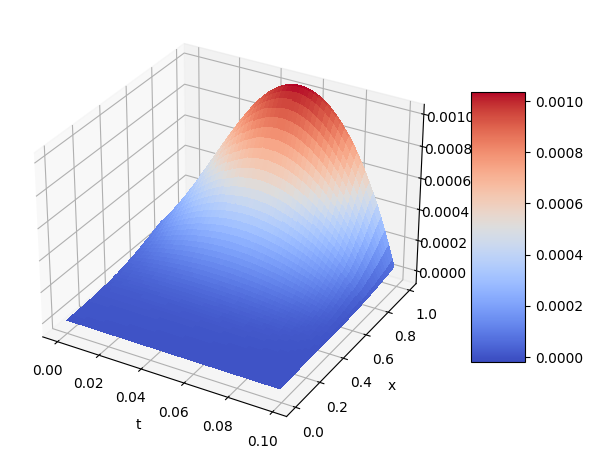

In [23]:
sol.plot2d()